In [3]:
# ===============================
# 1. Імпорти
# ===============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

1. Підготовка даних
- Завантажуємо датасет
- Створюємо бінарну ціль `Test_Result_Normal`
- Видаляємо непотрібні колонки
- Робимо one-hot encoding категорій
- Нормалізуємо числові ознаки
- Додаємо intercept для моделі


In [4]:
data = pd.read_csv('healthcare_dataset.csv')  # змініть шлях на свій

# Бінарна ціль
data['Test_Result_Normal'] = (data['Test Results'] == 'Normal').astype(int)

# Видалення непотрібних колонок
drop_cols = ['Name', 'Date of Admission', 'Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Test Results']
data.drop(columns=drop_cols, inplace=True, errors='ignore')

# One-hot encoding для категорій
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Нормалізація числових колонок
numeric_cols = ['Age', 'Billing Amount']
for col in numeric_cols:
    if col in data.columns:
        data[col] = (data[col] - data[col].mean()) / data[col].std()

# Ознаки та ціль
X = data.drop(columns=['Test_Result_Normal']).values.astype(float)
y = data['Test_Result_Normal'].values.astype(float)

# Додавання intercept
X = np.hstack([np.ones((X.shape[0],1)), X])


2. Кореляційна матриця
Мета: побачити зв’язки між числовими ознаками та цільовою змінною.


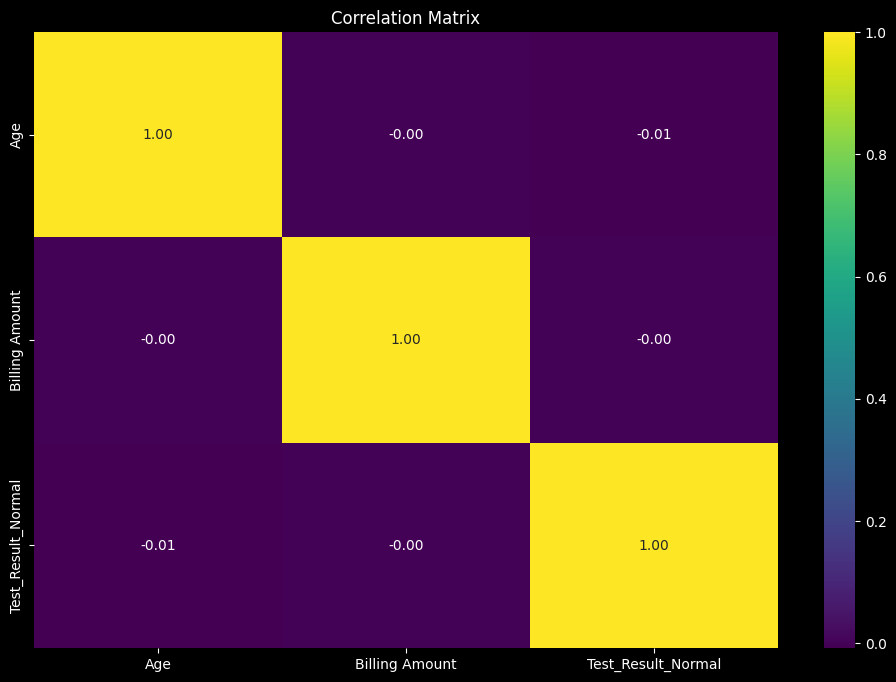

In [5]:
corr_cols = numeric_cols + ['Test_Result_Normal']
plt.figure(figsize=(12,8))
sns.heatmap(data[corr_cols].corr(), annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Matrix")
plt.show()


3. Розподіл даних
Розділяємо на навчальний, валідаційний та тестовий набори.


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, weights, l2_lambda=0.0, l1_lambda=0.0):
    preds = sigmoid(X @ weights)
    eps = 1e-15
    loss = -np.mean(y*np.log(preds+eps) + (1-y)*np.log(1-preds+eps))
    loss += l2_lambda*np.sum(weights[1:]**2)/2
    loss += l1_lambda*np.sum(np.abs(weights[1:]))
    return loss

def compute_gradients(X, y, weights, l2_lambda=0.0, l1_lambda=0.0, weights_dict=None):
    preds = sigmoid(X @ weights)
    errors = preds - y
    if weights_dict is not None:
        sample_weights = np.array([weights_dict[int(label)] for label in y])
        errors *= sample_weights
    grad = (X.T @ errors) / X.shape[0]
    grad[1:] += l2_lambda * weights[1:] + l1_lambda*np.sign(weights[1:])
    return grad

def get_batches(X, y, batch_size=32):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start in range(0, X.shape[0], batch_size):
        end = start+batch_size
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

def initialize_weights(n_features):
    return np.zeros(n_features)

def train_logistic_regression(X_train, y_train, X_val, y_val,
                              learning_rate=0.01, max_epochs=100,
                              batch_size=None, patience=100,
                              l2_lambda=0.001, l1_lambda=0.0,
                              weights_dict=None):
    """
    Універсальна функція навчання логістичної регресії
    з підтримкою SGD і Mini-batch.
    - Логування втрат після кожного батчу (Mini-batch) або після епохи (SGD)
      для плавних кривих.
    - Early stopping враховує середню втрату валідного набору по епосі.
    """
    weights = initialize_weights(X_train.shape[1])
    best_val_loss = float('inf')
    best_weights = weights.copy()
    epochs_no_improve = 0

    # Списки для графіків
    train_losses = []
    val_losses = []

    # Списки для Early stopping (по епохах)
    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in range(max_epochs):
        # Перетасування даних на кожну епоху
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        batch_val_losses = []

        if batch_size is None:  # SGD
            for xi, yi in zip(X_shuffled, y_shuffled):
                xi = xi.reshape(1, -1)
                yi = np.array([yi])
                grad = compute_gradients(xi, yi, weights, l2_lambda, l1_lambda, weights_dict)
                weights -= learning_rate * grad

            # Втрати після епохи
            train_loss_epoch = compute_loss(X_train, y_train, weights, l2_lambda, l1_lambda)
            val_loss_epoch = compute_loss(X_val, y_val, weights, l2_lambda, l1_lambda)

            train_losses.append(train_loss_epoch)
            val_losses.append(val_loss_epoch)
            train_losses_epoch.append(train_loss_epoch)
            val_losses_epoch.append(val_loss_epoch)

        else:  # Mini-batch
            
            for start in range(0, X_train.shape[0], batch_size):
                end = min(start + batch_size, X_train.shape[0])
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                grad = compute_gradients(X_batch, y_batch, weights, l2_lambda, l1_lambda, weights_dict)
                weights -= learning_rate * grad

                # Логування для плавного графіку
                train_losses.append(compute_loss(X_train, y_train, weights, l2_lambda, l1_lambda))
                val_batch_loss = compute_loss(X_val, y_val, weights, l2_lambda, l1_lambda)
                val_losses.append(val_batch_loss)
                batch_val_losses.append(val_batch_loss)

            # Середнє по епосі для Early stopping
            train_losses_epoch.append(np.mean([compute_loss(X_train, y_train, weights, l2_lambda, l1_lambda)]))
            val_losses_epoch.append(np.mean(batch_val_losses))

        # Early stopping
        if val_losses_epoch[-1] < best_val_loss:
            best_val_loss = val_losses_epoch[-1]
            best_weights = weights.copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return best_weights, train_losses, val_losses, train_losses_epoch, val_losses_epoch


In [8]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {i: w for i, w in enumerate(class_weights)}


4. Навчання моделей

У цьому розділі проводиться навчання двох варіантів лінійної моделі:

SGD (Stochastic Gradient Descent) — оновлення вагів відбувається після кожного окремого прикладу навчальної вибірки.

Mini-Batch Gradient Descent — використовується пакетний режим із розміром міні-батчу 32, що дозволяє поєднати стабільність batch-методу та швидкість SGD.

In [9]:
# SGD
weights_sgd, train_losses_sgd, val_losses_sgd, train_losses_epoch_sgd, val_losses_epoch_sgd = train_logistic_regression(
    X_train, y_train, X_val, y_val, learning_rate=0.001,
    batch_size=None, max_epochs=100, weights_dict=weights_dict, l2_lambda=0.001, l1_lambda=0.0
)

# Mini-batch
weights_mb, train_losses_mb, val_losses_mb, train_losses_epoch_mb, val_losses_epoch_mb = train_logistic_regression(
    X_train, y_train, X_val, y_val, learning_rate=0.001,
    batch_size=32, max_epochs=100, weights_dict=weights_dict, l2_lambda=0.001, l1_lambda=0.0
)

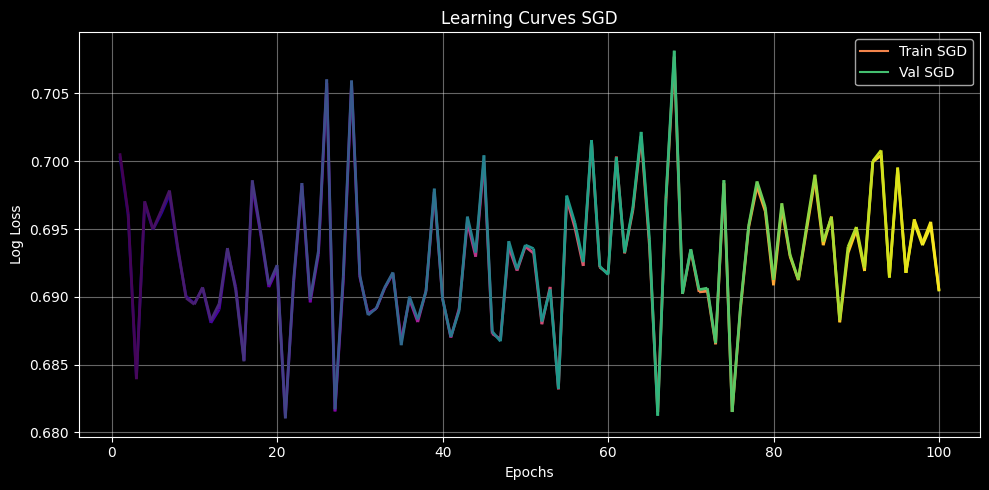

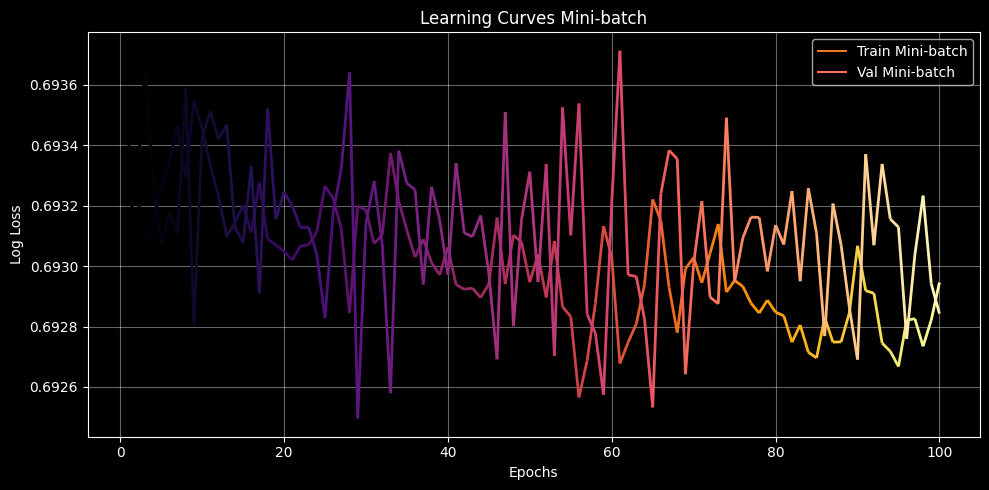

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_gradient_line(x, y, cmap_name="viridis", label=None, linewidth=2):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize(x.min(), x.max())

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(x)
    lc.set_linewidth(linewidth)

    plt.gca().add_collection(lc)
    if label:
        plt.plot([], [], color=cmap(0.7), label=label)  # легенда


plt.style.use('dark_background')

# SGD
epochs_sgd = np.arange(1, len(train_losses_sgd) + 1)

plt.figure(figsize=(10,5))
plot_gradient_line(epochs_sgd, train_losses_sgd, cmap_name="plasma", label="Train SGD")
plot_gradient_line(epochs_sgd, val_losses_sgd, cmap_name="viridis", label="Val SGD")
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Learning Curves SGD')
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# Mini-batch
epochs_mb = np.arange(1, len(train_losses_epoch_mb) + 1)

plt.figure(figsize=(10,5))
plot_gradient_line(epochs_mb, train_losses_epoch_mb, cmap_name="inferno", label="Train Mini-batch")
plot_gradient_line(epochs_mb, val_losses_epoch_mb, cmap_name="magma", label="Val Mini-batch")
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Learning Curves Mini-batch')
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.style.use('default')



5. Оцінка моделей
Використовуємо стандартні метрики: Accuracy, Precision, Recall, F1-score.


In [11]:
def evaluate_model(X, y, weights):
    preds = sigmoid(X @ weights) >= 0.5
    cm = confusion_matrix(y, preds)
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    return cm, acc, prec, rec, f1

cm_sgd, acc_sgd, prec_sgd, rec_sgd, f1_sgd = evaluate_model(X_test, y_test, weights_sgd)
cm_mb, acc_mb, prec_mb, rec_mb, f1_mb = evaluate_model(X_test, y_test, weights_mb)


6. Порівняльна таблиця метрик


In [12]:
metrics_table = pd.DataFrame({
    'Method': ['SGD', 'Mini-batch'],
    'Accuracy': [acc_sgd, acc_mb],
    'Precision': [prec_sgd, prec_mb],
    'Recall': [rec_sgd, rec_mb],
    'F1-score': [f1_sgd, f1_mb]
})
metrics_table


,Method,Accuracy,Precision,Recall,F1-score
0,SGD,0.634685,0.35259,0.094174,0.148646
1,Mini-batch,0.496757,0.33937,0.513434,0.408639


7. Матриці плутанини

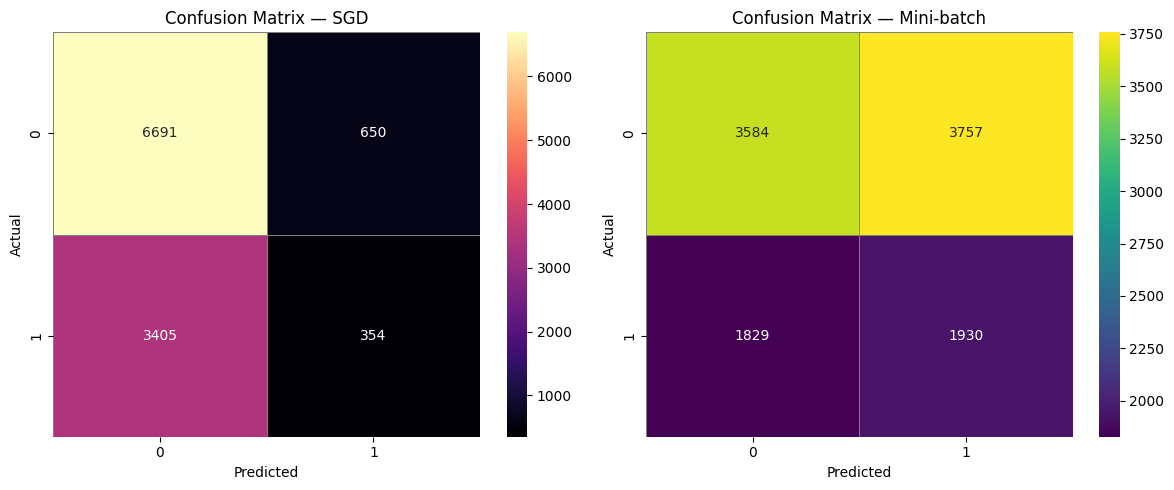

In [15]:
plt.figure(figsize=(12,5))

# --- SGD ---
plt.subplot(1, 2, 1)
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='magma', linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix — SGD', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# --- Mini-batch ---
plt.subplot(1, 2, 2)
sns.heatmap(cm_mb, annot=True, fmt='d', cmap='viridis', linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix — Mini-batch', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()



8. Висновок

In [14]:
def generate_summary(metrics_df):
    summary = "Висновок результатів роботи методів оптимізації\n\n"
    for idx, row in metrics_df.iterrows():
        summary += f"Метод: **{row['Method']}**\n"
        summary += f"- Accuracy: {row['Accuracy']:.3f}\n"
        summary += f"- Precision: {row['Precision']:.3f}\n"
        summary += f"- Recall: {row['Recall']:.3f}\n"
        summary += f"- F1-score: {row['F1-score']:.3f}\n"
        
        if row['F1-score'] < 0.2:
            summary += "- Модель має суттєві труднощі з визначенням менш представленого класу.\n"
        elif row['F1-score'] < 0.4:
            summary += "- Модель показує середній рівень класифікації обох класів.\n"
        else:
            summary += "- Модель демонструє впевнену якість класифікації для обох класів.\n"
        
        summary += "\n"
    
    # Загальний висновок
    best_method = metrics_df.loc[metrics_df['F1-score'].idxmax()]['Method']
    summary += (
        f"У підсумку, метод **{best_method}** забезпечив найкраще співвідношення "
        "точності та повноти серед усіх протестованих підходів.\n"
    )
    summary += "Застосування регуляризації та методів балансування сприяло покращенню узагальнюючої здатності моделі."
    
    return summary

# Виводимо автоматичний висновок
auto_summary = generate_summary(metrics_table)
from IPython.display import Markdown
display(Markdown(auto_summary))


Висновок результатів роботи методів оптимізації

Метод: **SGD**
- Accuracy: 0.635
- Precision: 0.353
- Recall: 0.094
- F1-score: 0.149
- Модель має суттєві труднощі з визначенням менш представленого класу.

Метод: **Mini-batch**
- Accuracy: 0.497
- Precision: 0.339
- Recall: 0.513
- F1-score: 0.409
- Модель демонструє впевнену якість класифікації для обох класів.

У підсумку, метод **Mini-batch** забезпечив найкраще співвідношення точності та повноти серед усіх протестованих підходів.
Застосування регуляризації та методів балансування сприяло покращенню узагальнюючої здатності моделі.

**Загальні висновки:**  
- Регуляризація та балансування класів допомагають покращити узагальнення моделі.  
- Для задачі прогнозування результатів тестів більш доцільно застосовувати метод **SGD з регуляризацією та врахуванням класів**.  
- Загальна точність обох моделей залишається помірною, тому варто розглянути додаткові ознаки або збалансованіший набір даних для підвищення ефективності.
